In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/serengil/tensorflow-101/blob/master/python/opencv-dnn-face-detection.ipynb
# https://github.com/AyushExel/ml4face-detection/blob/master/Final-Face%20Detection%20Notebook.ipynb

# https://raw.githubusercontent.com/opencv/opencv/4.5.4/samples/dnn/face_detector/deploy.prototxt
# https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

# OpenCV DNN Face Detector based on ResNet-10 Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class ResNetDetector(Detector):
    TARGET_SIZE = (300, 300)
    
    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        self.detector = cv2.dnn.readNetFromCaffe("./models/resnet/deploy.prototxt.txt", "./models/resnet/res10_300x300_ssd_iter_140000.caffemodel")
    
    def detect(self, image):
        (h, w) = image.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))

        self.detector.setInput(blob)
        detections = self.detector.forward()
        
        boxes = []
        confidence = []
        
        for i in range(0, detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf > 0.5:
                confidence.append(conf)
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                boxes.append([startX, startY, endX, endY])

        return boxes, confidence
    
resnet = ResNetDetector()

In [4]:
with TsvHandle('resnet') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = resnet, 
        cv2_filter = cv2.COLOR_RGB2BGR
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [3226/3226]
./results/resnet-20220614-101054.tsv
./results/resnet-20220614-101054-ap.tsv
./results/resnet-20220614-101054-load.tsv
./results/resnet-20220614-101054-metadata.tsv


In [5]:
with TsvHandle('resnet_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = resnet, 
        cv2_filter = cv2.COLOR_RGB2BGR,
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [3226/3226]
./results/resnet_filtered-20220614-101348.tsv
./results/resnet_filtered-20220614-101348-ap.tsv
./results/resnet_filtered-20220614-101348-load.tsv
./results/resnet_filtered-20220614-101348-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-14 10:10:54.507374,2.7,6359646208
1,2022-06-14 10:11:05.532682,38.6,5922439168
2,2022-06-14 10:11:16.556180,33.1,5929906176
3,2022-06-14 10:11:27.586930,41.3,5933744128
4,2022-06-14 10:11:38.613930,39.1,5927006208
5,2022-06-14 10:11:49.615430,42.4,5950144512
6,2022-06-14 10:12:00.622430,45.3,5950013440
7,2022-06-14 10:12:11.629930,40.2,5935693824
8,2022-06-14 10:12:23.110930,36.6,5921718272
9,2022-06-14 10:12:34.122430,38.2,5942521856


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

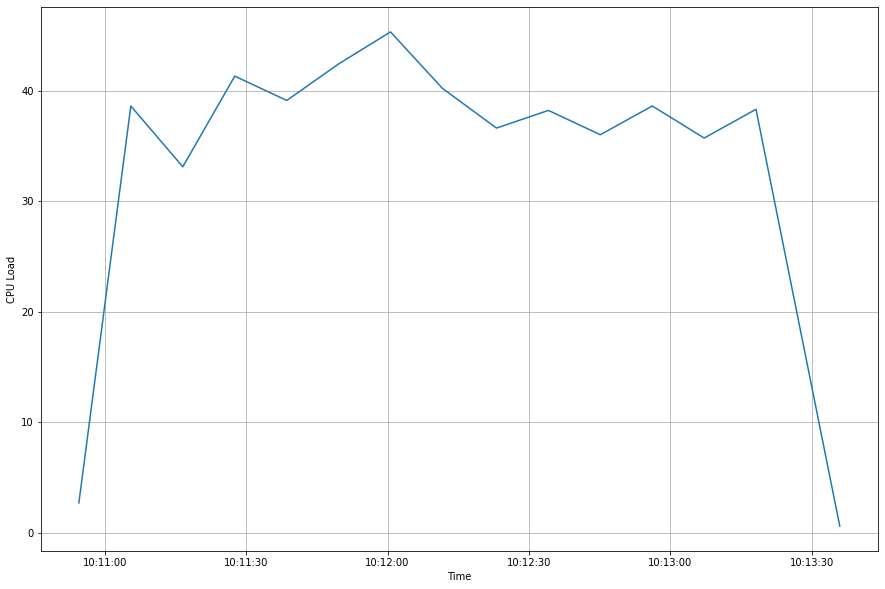

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

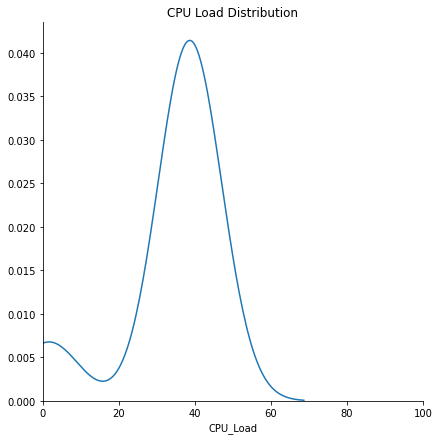

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

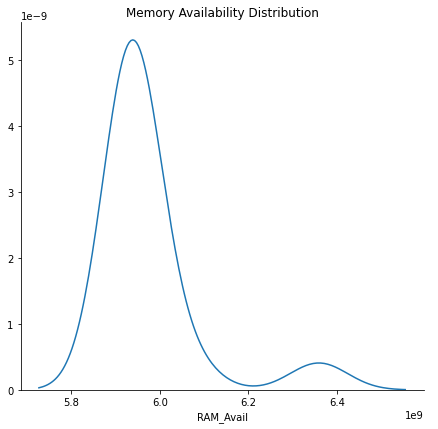

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-14 10:10:55.285181,52019900,1.0,0.75,0.857143,"[0.862749790594711, 0.7594473791141813, 0.8057...",6,0,2,8,"[(785.0, 184.0, 856.0, 293.0), (305.0, 145.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-14 10:10:55.313681,23070500,0.0,0.00,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-06-14 10:10:55.342681,21869700,0.0,0.00,0.000000,[0.04060947778225265],0,1,2,2,"[(471.0, 82.0, 705.0, 464.0)]","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-06-14 10:10:55.442181,20960200,0.0,0.00,0.000000,[],0,0,62,62,[],"[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-06-14 10:10:55.477680,20897500,1.0,0.25,0.400000,"[0.7648351648351648, 0.8314950980392157]",2,0,6,8,"[(99.0, 76.0, 155.0, 141.0), (269.0, 66.0, 320...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-06-14 10:13:25.755930,22059900,1.0,1.00,1.000000,[0.9069478908188585],1,0,0,1,"[(458.0, 140.0, 590.0, 333.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-06-14 10:13:25.785430,21028800,1.0,1.00,1.000000,"[0.8372409106354061, 0.8802442215438291]",2,0,0,2,"[(713.0, 405.0, 795.0, 547.0), (322.0, 406.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-06-14 10:13:25.859931,21047200,0.0,0.00,0.000000,[],0,0,27,27,[],"[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-06-14 10:13:25.899930,20905300,0.0,0.00,0.000000,[],0,0,7,7,[],"[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.199310e+07,0.567387,0.427852,0.453423,1.050527,0.021699,11.258215,12.308741
std,1.050845e+06,0.492628,0.453465,0.452844,1.469141,0.149916,39.938891,39.822258
min,2.047120e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.141465e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.186985e+07,1.000000,0.190909,0.320513,1.000000,0.000000,1.000000,3.000000
75%,2.232728e+07,1.000000,1.000000,1.000000,1.000000,0.000000,8.000000,9.000000
max,5.201990e+07,1.000000,1.000000,1.000000,16.000000,2.000000,709.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count    3226.000000
mean       21.993069
std         1.050787
min        20.470000
25%        21.412500
50%        21.870000
75%        22.330000
max        52.020000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000025,1.000000,0.000025,1.000000,0.000025
1,1.000000,True,True,True,1.000000,0.000050,1.000000,0.000050,1.000000,0.000050
2,1.000000,True,True,True,1.000000,0.000076,1.000000,0.000076,1.000000,0.000076
3,1.000000,True,True,True,1.000000,0.000101,1.000000,0.000101,1.000000,0.000101
4,0.999999,True,True,True,1.000000,0.000126,1.000000,0.000126,1.000000,0.000126
...,...,...,...,...,...,...,...,...,...,...
3454,0.502187,True,True,False,0.980029,0.085272,0.972793,0.084643,0.764978,0.066561
3455,0.501359,True,True,True,0.980035,0.085298,0.972801,0.084668,0.765046,0.066586
3456,0.500528,True,True,True,0.980040,0.085323,0.972809,0.084693,0.765114,0.066611
3457,0.500314,False,False,False,0.979757,0.085323,0.972527,0.084693,0.764893,0.066611


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,1.000000,True,True,True,1.000000,0.000140,1.000000,0.000140,1.000000,0.000140
1,1.000000,True,True,True,1.000000,0.000281,1.000000,0.000281,1.000000,0.000281
2,1.000000,True,True,True,1.000000,0.000421,1.000000,0.000421,1.000000,0.000421
3,1.000000,True,True,True,1.000000,0.000562,1.000000,0.000562,1.000000,0.000562
4,0.999999,True,True,True,1.000000,0.000702,1.000000,0.000702,1.000000,0.000702
...,...,...,...,...,...,...,...,...,...,...
3415,0.502187,True,True,False,0.987412,0.473669,0.980679,0.470440,0.773712,0.371156
3416,0.501359,True,True,True,0.987416,0.473810,0.980685,0.470580,0.773778,0.371296
3417,0.500528,True,True,True,0.987420,0.473950,0.980690,0.470720,0.773844,0.371437
3418,0.500314,False,False,False,0.987131,0.473950,0.980404,0.470720,0.773618,0.371437


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

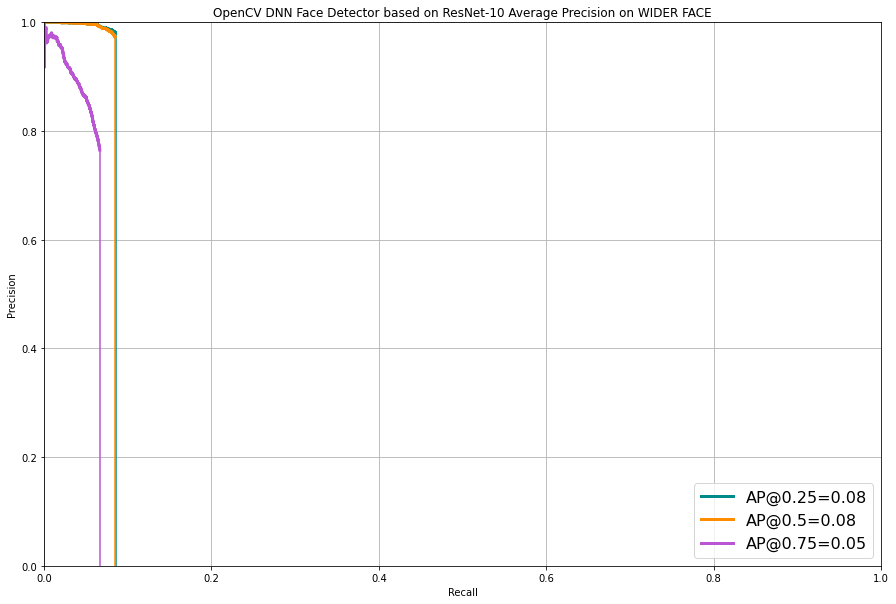

In [19]:
plot_pr(df_ap, 'OpenCV DNN Face Detector based on ResNet-10 Average Precision on WIDER FACE')

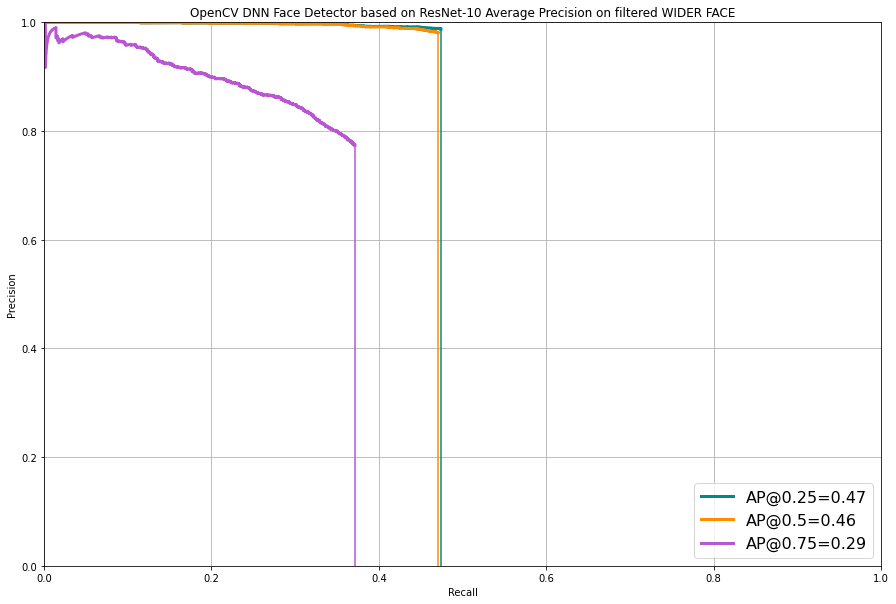

In [20]:
plot_pr(df_ap_filtered, 'OpenCV DNN Face Detector based on ResNet-10 Average Precision on filtered WIDER FACE')

# OpenCV DNN Face Detector based on ResNet-10 Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class ResNetDetector(Detector):
    TARGET_SIZE = (300, 300)
    
    CONF_THRESHOLD = 0.5
    NMS_THRESHOLD = 0.4
    
    def __init__(self):
        self.detector = cv2.dnn.readNetFromCaffe("./models/resnet/deploy.prototxt.txt", "./models/resnet/res10_300x300_ssd_iter_140000.caffemodel")
    
    def detect(self, image):
        (h, w) = image.shape[:2]
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,
            (300, 300), (104.0, 177.0, 123.0))

        self.detector.setInput(blob)
        detections = self.detector.forward()
        
        boxes = []
        confidence = []
        
        for i in range(0, detections.shape[2]):
            conf = detections[0, 0, i, 2]
            if conf > 0.5:
                confidence.append(conf)
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                boxes.append([startX, startY, endX, endY])

        return boxes, confidence
    
resnet = ResNetDetector()

In [24]:
stt_aps, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=resnet,
    cv2_filter = cv2.COLOR_RGB2BGR,
    results_folder="resnet",
    save_videos=True
)

Frames: [====================] 100% [164/164], Videos: [216/216]

In [25]:
print("Mean Video STT-AP: {0:.2f}".format(np.mean(stt_aps)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-AP: 0.65
Mean detection percentage of faces in all videos: 58.60
Mean confidence of boxes in all videos: 0.89
Mean inference time for all frames: 23.93ms
